# Practical 06 - Generative Adversarial Networks

In this practical we will learn how to train and use a Generative Adversarial Network.

## Section 6.2.1 - Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls /content/drive/My\ Drive/Data/D6

x_gray.npy  x.npy


## Section 6.2.2 - Importing Dependencies

Let's import our dependencies. Remember to set the folder where you want to save your models / generated image samples.


In [3]:
# The original source code is referenced from:
#   https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py

import numpy as np
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Convolution2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

# TODO:
# Set the folder that you want to save the trained models and sample
# generated images to.
#
folder = '/content/drive/My Drive/Data/D6/'

width = 28
height = 28
channels = 1

## Section 6.2.3 - Load Up Our Training Data

For a start we are going to use our Fashion MNIST data to be our training data. This means that our GANs will generate images of shirts, shoes and pants, etc.


In [ ]:
# TODO:
# Load our data
#
#...#
# To load the Fashion MNIST data.
# channels = 1
# (x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
# x_train = x_train.reshape((x_train.shape[0], width*height*channels))
# x_train = x_train / 127.5 - 1.   # rescales the image's RGB components from -1 to 1

# If you want to load your Zappos grayscale dataset, use the following code instead:
channels = 1
x_train = np.load(folder + "x_gray.npy")
x_train = x_train.reshape((x_train.shape[0], width*height*channels))
x_train = x_train / 127.5 - 1.   # rescales the image's RGB components from -1 to 1


## Section 6.2.4 - Declare Functions

Declare some functions that will help to save models and plot the loss and generated images.

In [0]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch, d, g):
    plt.figure(figsize=(8, 3))
    plt.plot(d, label='Discriminative loss')
    plt.plot(g, label='Generative loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    #plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

def normalize(img):
    imgmax = np.max(img)
    imgmin = np.min(img)
    imgdiff = (imgmax - imgmin)
    #print (imgdiff)
    if imgdiff != 0:
        return (img - imgmin) / imgdiff
    return img

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, g, examples=25, dim=(5, 5), figsize=(8, 8)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = g.predict(noise)
    
    if channels == 1:
        generatedImages = generatedImages.reshape(examples, width, height)
    else:
        generatedImages = generatedImages.reshape(examples, width, height, channels)
    
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        generatedImages[i] = normalize(generatedImages[i])
        #print (generatedImages[i])
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(folder + 'gan_generated_image_epoch_%d.png' % epoch)
    plt.show()

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch, g, d):
    g.save(folder + 'gan_generator_epoch.h5')
    d.save(folder + 'gan_discriminator_epoch.h5')


## Section 6.2.5 - Creating Our Model Architectures

GANs, as we learnt, are made up of two separate network models - the Generator and the Discriminator connected together.

Setting up a GAN with Keras requires us to put together a number of things we have already learnt:
- Dense layers for classification and hidden layers
- Convolutional layers for image feature extraction
- Other Keras layers such as activation layers, etc
- Functional API in Keras
- Layer / model freezing


In [0]:
# Set the random input vector size to 10.
#
# Look at the random vector that starts off with no meaning,
# but as the training progresses, it turns into a "feature map" telling
# how the generator generates the output.
#
randomDim = 10

# Optimizer
#
d_optimizer = Adam(lr=0.0002, beta_1=0.5)
g_optimizer = Adam(lr=0.0002, beta_1=0.5)

#------------------------------------------------------------------

# TODO:
# Let's create the generator network
#
def create_generator_model():

    model = Sequential()

    model.add(Dense(256, input_shape=(randomDim, )))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(width * height, activation='tanh'))
    model.add(Reshape((height, width, 1)))
    model.compile(loss='binary_crossentropy', optimizer=g_optimizer)
    model.summary()  
    return model


#------------------------------------------------------------------

# TODO:
# Then, create the discriminator network
#
def create_discriminator_model():

    model = Sequential()

    model.add(Flatten(input_shape=(height, width, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=d_optimizer)
    model.summary()

    return model

#------------------------------------------------------------------

def create_gan_model():

    # Create the generator model
    #
    generator = create_generator_model()

    # Create the discriminator model
    #
    discriminator = create_discriminator_model()
    discriminator.trainable = False

    # Combine the two networks using the Keras functional API.
    #
    ganInput = Input(shape=(randomDim,))
    ganOutput = generator(ganInput)
    ganOutput = discriminator(ganOutput)
    ganOutput = Model(inputs=ganInput, outputs=ganOutput)
    ganOutput.summary()
    ganOutput.compile(loss='binary_crossentropy', optimizer=g_optimizer)

    gan = ganOutput

    return generator, discriminator, gan

## Section 6.2.6 - Our Custom GAN Training Code

Below section performs discriminator training and the generator training. In generator training "d" model is non-trainable?

 The explanation for the parameters are as follows:
- Parameter 1: Number of epochs, 
- Parameter 2: Batch size
- Parameter 3: Number of training iterations on D and G per batch of data

This should take about 1 hour to run on Google Colab.


In [15]:
g, d, gan = create_gan_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_11 (Dense)             (None, 1024)             

Epochs: 20
Batch size: 128
Batches per epoch: 391
---------------Epoch 1---------------


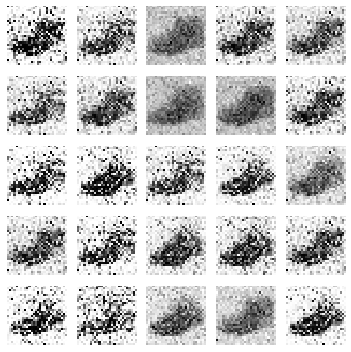

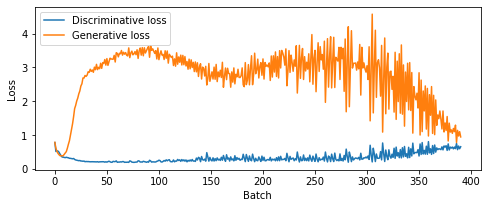

---------------Epoch 2---------------


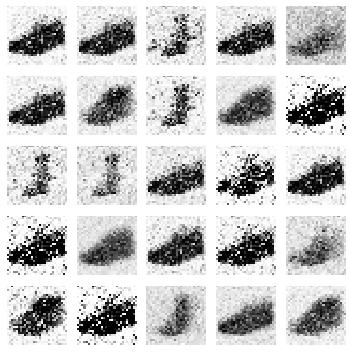

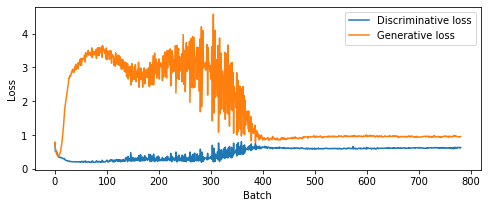

---------------Epoch 3---------------


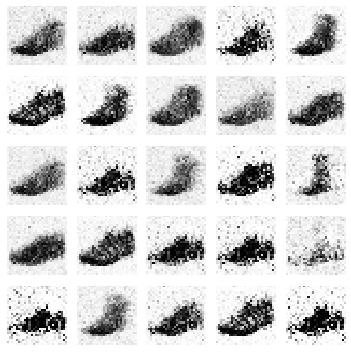

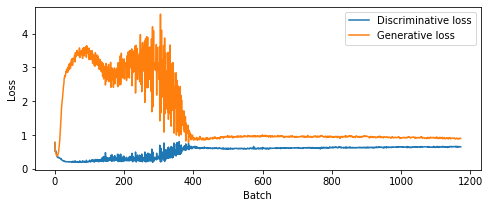

---------------Epoch 4---------------


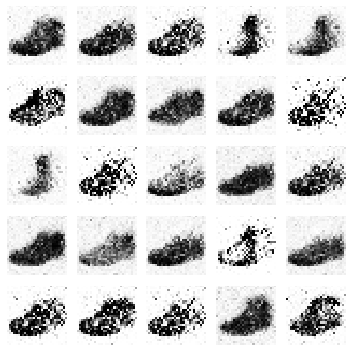

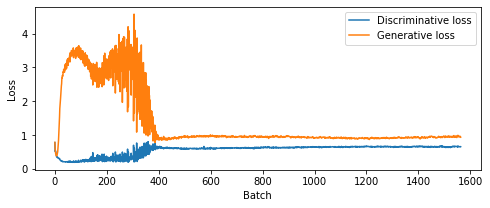

---------------Epoch 5---------------


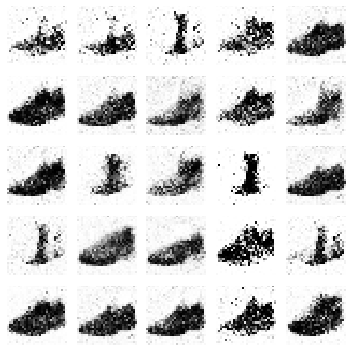

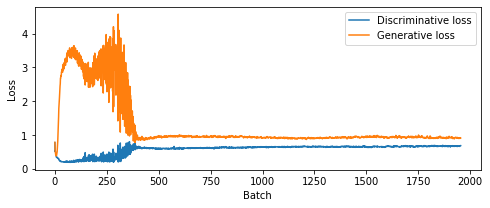

---------------Epoch 6---------------


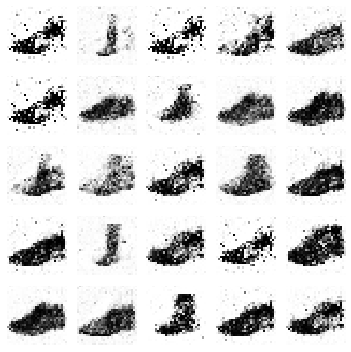

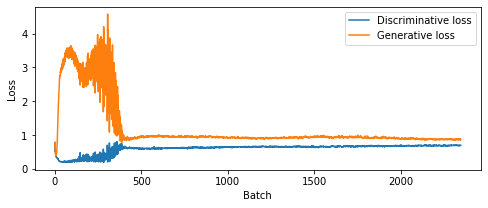

---------------Epoch 7---------------


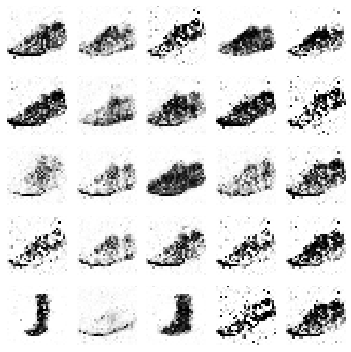

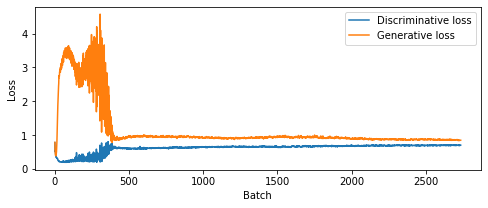

---------------Epoch 8---------------


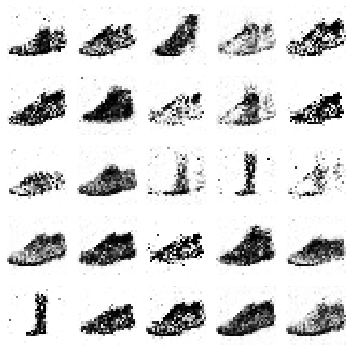

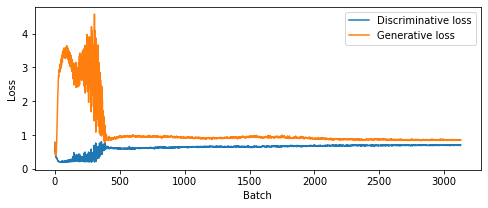

---------------Epoch 9---------------


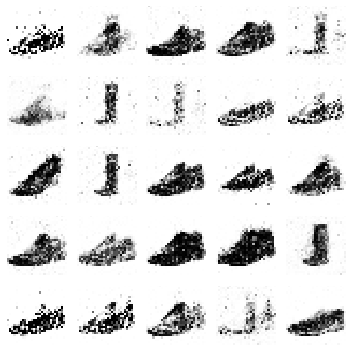

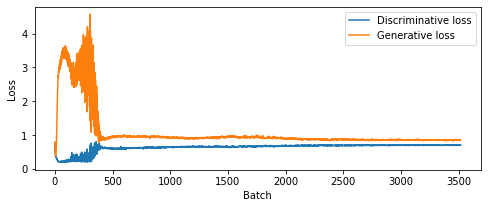

---------------Epoch 10---------------


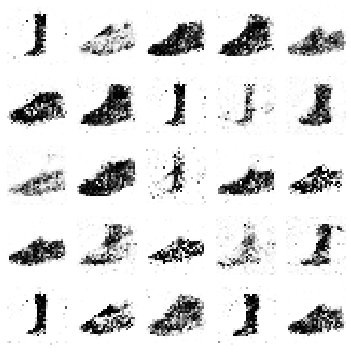

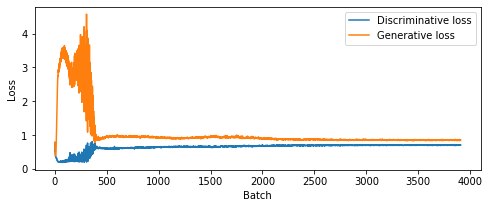

---------------Epoch 11---------------


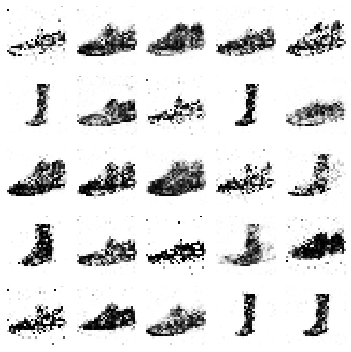

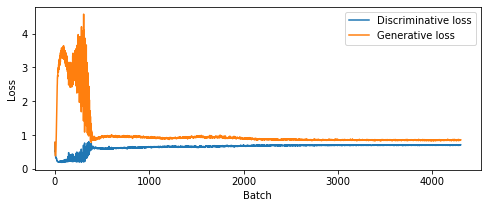

---------------Epoch 12---------------


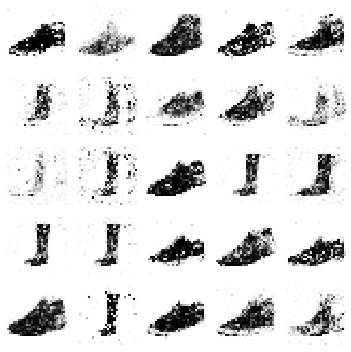

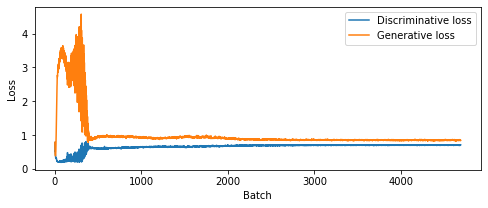

---------------Epoch 13---------------


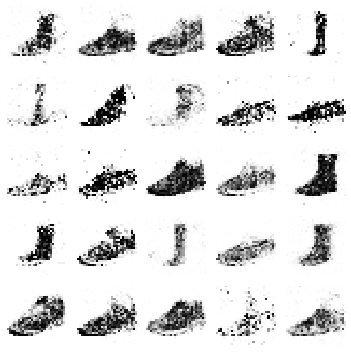

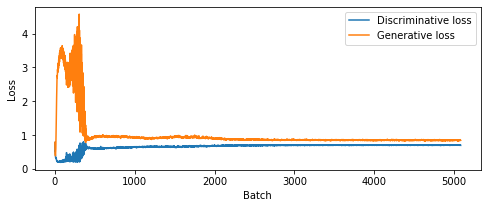

---------------Epoch 14---------------


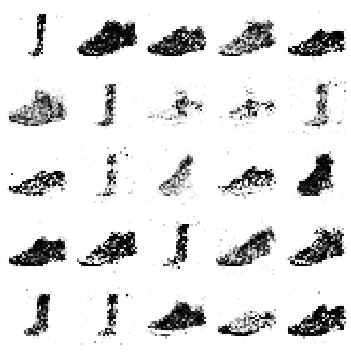

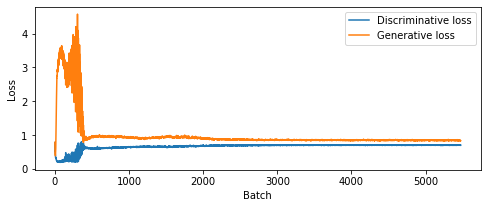

---------------Epoch 15---------------


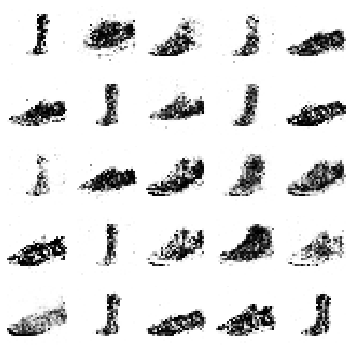

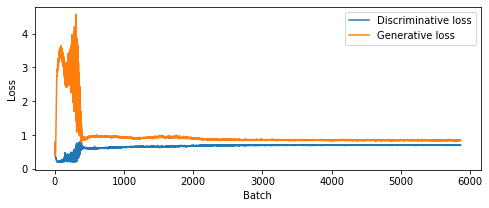

---------------Epoch 16---------------


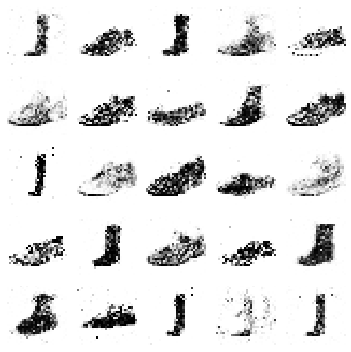

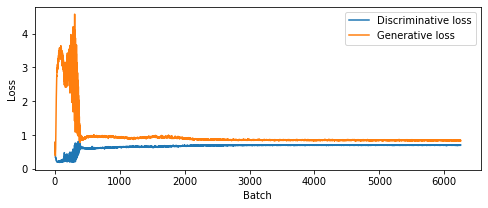

---------------Epoch 17---------------


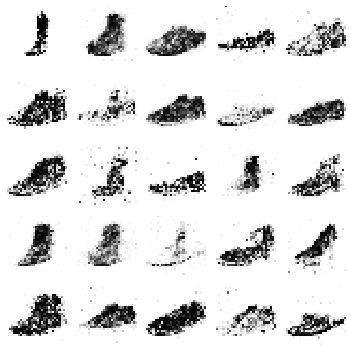

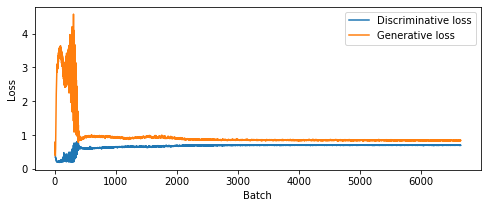

---------------Epoch 18---------------


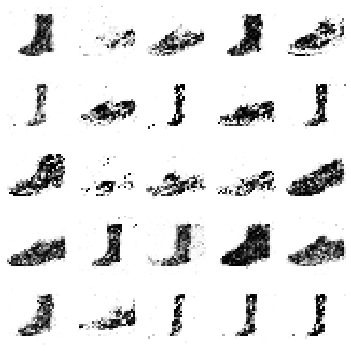

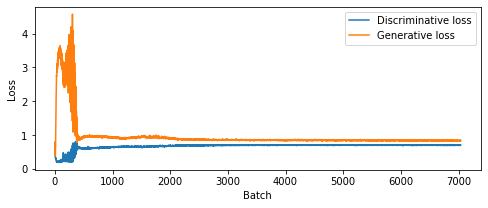

---------------Epoch 19---------------


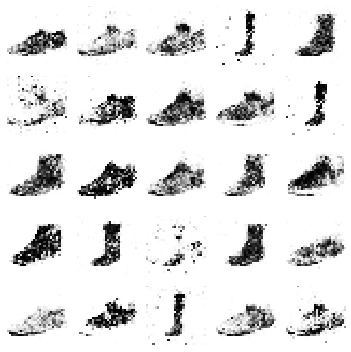

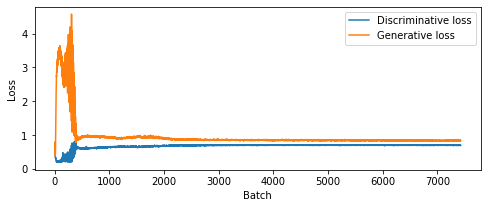

---------------Epoch 20---------------


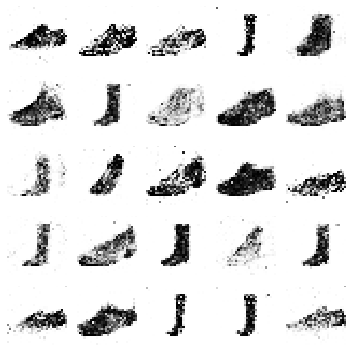

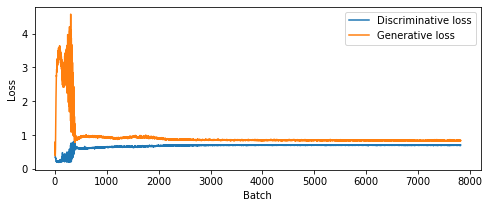

In [16]:
def train_gan(epochs=1, batchSize=128, d_train_iterations=1, g_train_iterations=1):
    global g, d, gan

    batchCount = int(x_train.shape[0] / batchSize)
    print ('Epochs: %d' % epochs)
    print ('Batch size: %d' % batchSize)
    print ('Batches per epoch: %d' % batchCount)
    dLosses = []
    gLosses = []


    for epoch in range(1, epochs+1):
        print ('-'*15 + ('Epoch %d' % epoch) + '-'*15)

        totalDLoss = 0
        totalGLoss = 0

        for i in tqdm_notebook(range(batchCount)):
            #print (i)
            # -----------------------------
            #   Discriminator Training
            # -----------------------------

            # Get a batch of real images from our data set
            #
            random_idx = np.random.randint(0, x_train.shape[0], batchSize)
            xReal = x_train[random_idx].reshape(batchSize, height, width, channels)

            # Generate fake images with our generator
            #
            noise = np.random.normal(-1, 1, size=[batchSize, randomDim])
            xFake = g.predict(noise)

            # Generate the actual Y labels for training
            #
            yReal = np.array([0.9] * batchSize)
            yFake = np.zeros(batchSize)

            # Train discriminator (but not the generator)
            #
            # TODO:
            #...#
            d.trainable = True
            dLoss = 0
            for it in range(0, d_train_iterations):
                dLoss += d.train_on_batch(xReal, yReal)
                dLoss += d.train_on_batch(xFake, yFake)
            dLosses.append(dLoss / 2)

            # -----------------------------
            #   Generator Training
            # -----------------------------

            yReal = np.ones(batchSize)

            # Train generator (but not the discriminator)
            # to output images that the discriminator will classify
            # as real.
            #
            # TODO:
            #...#
            d.trainable = False
            for it in range(0, g_train_iterations):
                noise = np.random.normal(-1, 1, size=[batchSize, randomDim])
                gLoss = gan.train_on_batch(noise, yReal)
            gLosses.append(gLoss)

        # Store loss of most recent batch from this epoch
        # for plotting.
        #
        #dLosses.append(totalDLoss / batchSize)
        #gLosses.append(totalGLoss / batchSize)
        
        #print ("Training loss: G=%f, D=%f" % (dloss, gloss))
        #print (dLosses)
        #print (gLosses)

        #if e == 1 or e % 20 == 0:
        plotGeneratedImages(epoch, g, 25, [5,5], [5,5])
        saveModels(epoch, g, d)

        # Plot losses from every epoch
        plotLoss(epoch, dLosses, gLosses)

    return gan


#print (x_train.shape)

# TODO:
# Finally, train our model here:
#
#...#
# train_gan(200, 128)   ## practical is 200 epochs
train_gan(20, 128)      ## change to 20 epochs to reduce run time

## Section 6.2.7 - Attempting to Construct Our DCGAN

Run the code below, as is, to construct our Deep Convolutional GAN.

In [0]:
# Set the random input vector size to 10.
#
# Look at the random vector that starts off with no meaning,
# but as the training progresses, it turns into a "feature map" telling
# how the generator generates the output.
#
# TODO:
#
randomDim = 10

# Optimizer
#
d_optimizer = Adam(lr=0.0002, beta_1=0.5)
g_optimizer = Adam(lr=0.0002, beta_1=0.5)

#------------------------------------------------------------------

# TODO:
# Let's create the generator network
#
def create_generator_model():
    
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_shape=(randomDim, )))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Convolution2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Convolution2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Convolution2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.compile(loss='binary_crossentropy', optimizer=g_optimizer)
    model.summary()
    return model

#------------------------------------------------------------------

# TODO:
# Then, create the discriminator network
#
def create_discriminator_model():

    model = Sequential()

    model.add(Convolution2D(32, kernel_size=3, strides=2, input_shape=[height, width, channels], padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Convolution2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Convolution2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=d_optimizer)
    model.summary()
    
    return model

#------------------------------------------------------------------

def create_gan_model():

    # Create the generator model
    #
    generator = create_generator_model()

    # Create the discriminator model
    #
    discriminator = create_discriminator_model()
    discriminator.trainable = False

    # Combine the two networks using the Keras functional API.
    #
    ganInput = Input(shape=(randomDim,))
    ganOutput = generator(ganInput)
    ganOutput = discriminator(ganOutput)
    ganOutput = Model(inputs=ganInput, outputs=ganOutput)
    ganOutput.summary()
    ganOutput.compile(loss='binary_crossentropy', optimizer=g_optimizer)

    gan = ganOutput

    return generator, discriminator, gan


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 6272)              68992     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 128)      

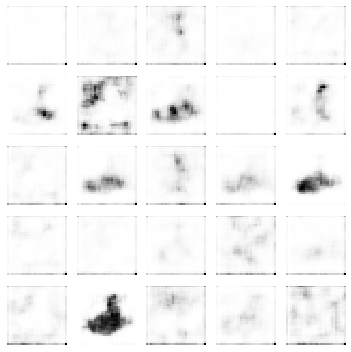

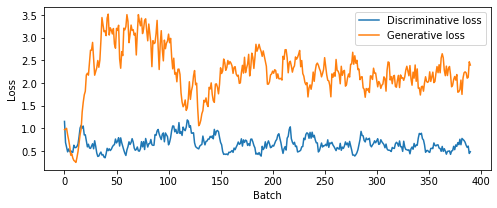

---------------Epoch 2---------------


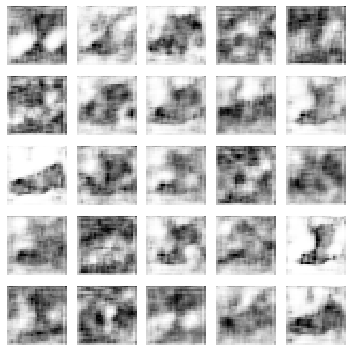

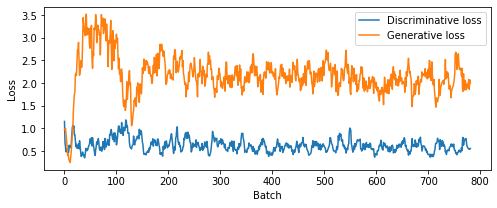

---------------Epoch 3---------------


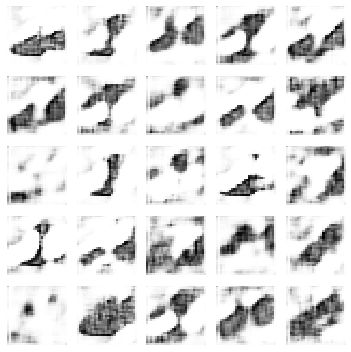

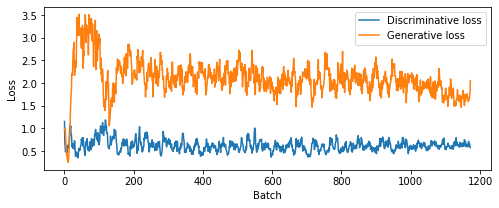

---------------Epoch 4---------------


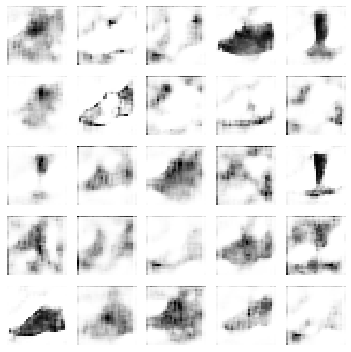

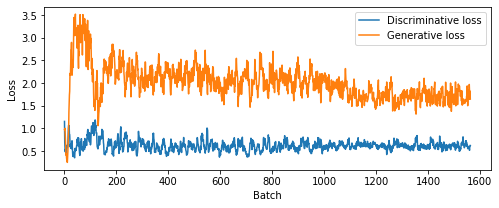

---------------Epoch 5---------------


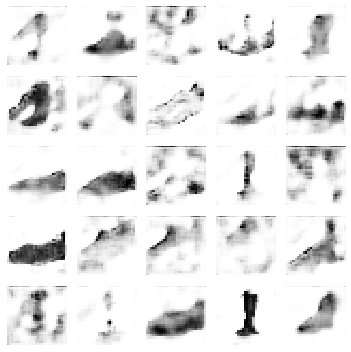

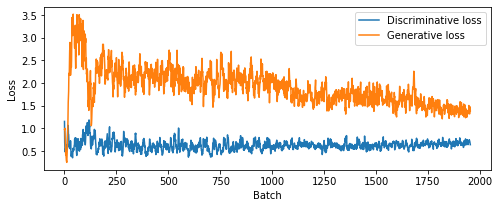

---------------Epoch 6---------------


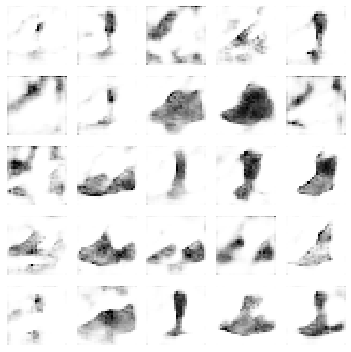

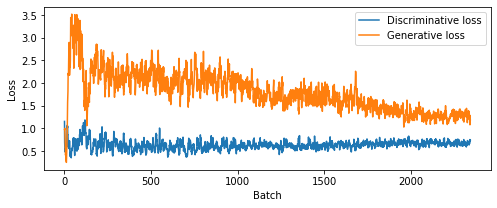

---------------Epoch 7---------------


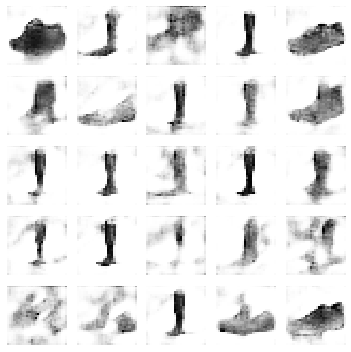

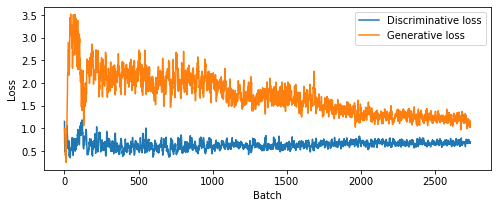

---------------Epoch 8---------------


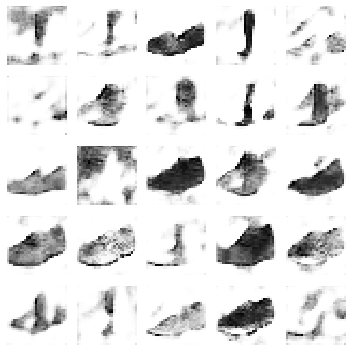

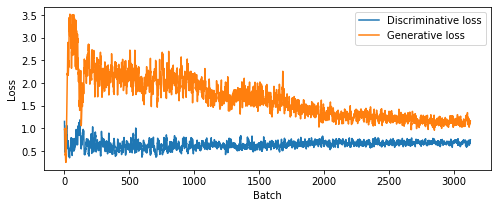

---------------Epoch 9---------------


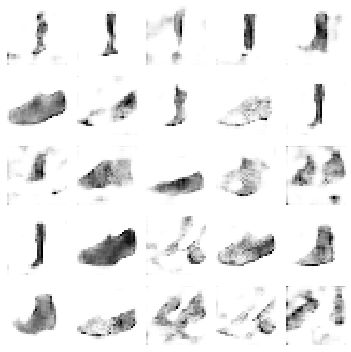

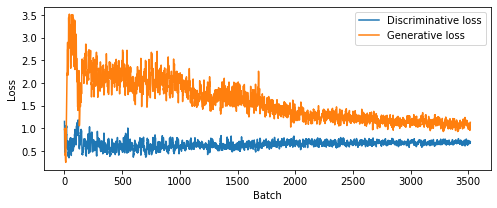

---------------Epoch 10---------------


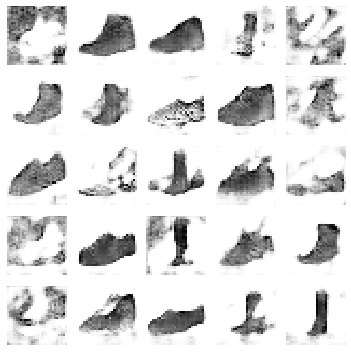

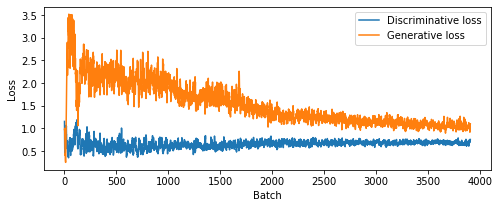

---------------Epoch 11---------------


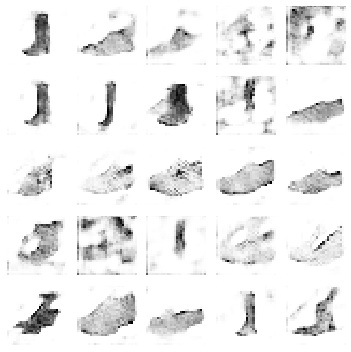

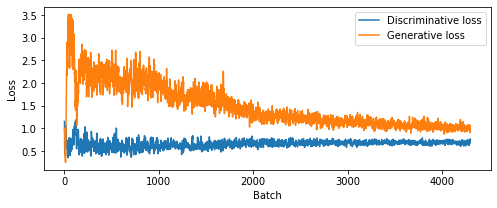

---------------Epoch 12---------------


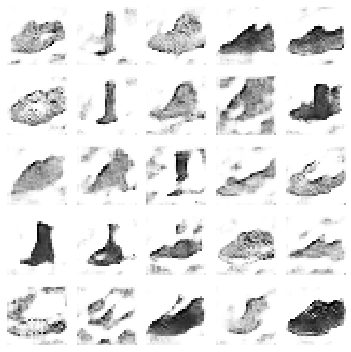

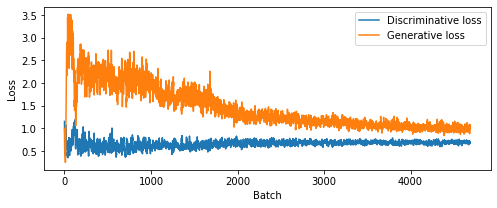

---------------Epoch 13---------------


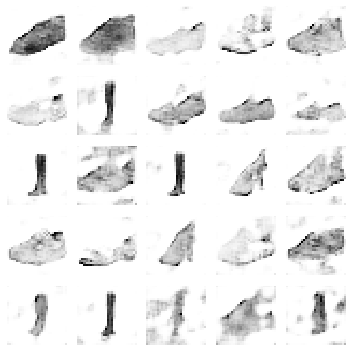

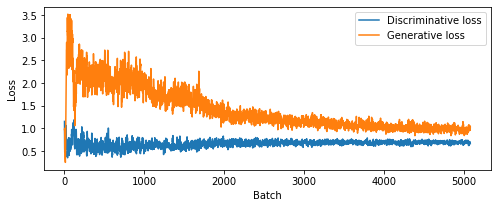

---------------Epoch 14---------------


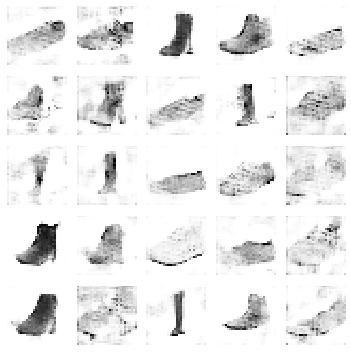

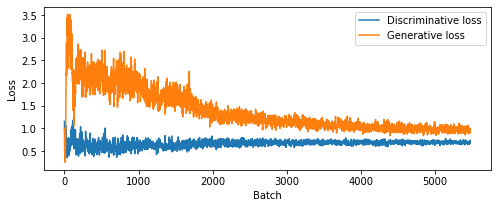

---------------Epoch 15---------------


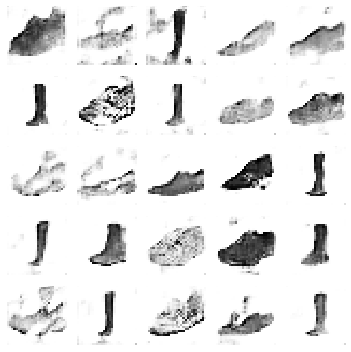

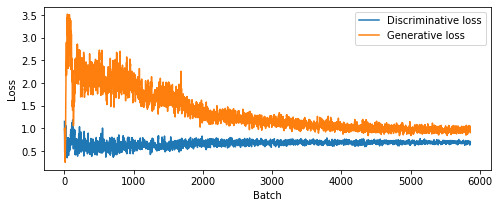

---------------Epoch 16---------------


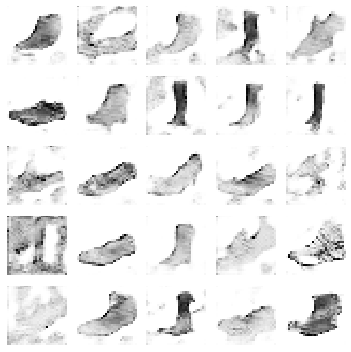

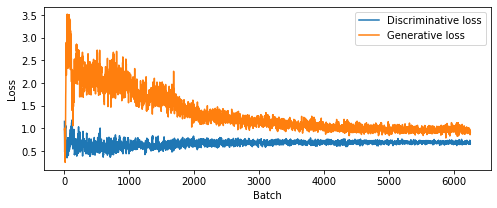

---------------Epoch 17---------------


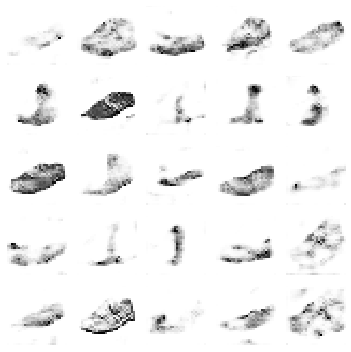

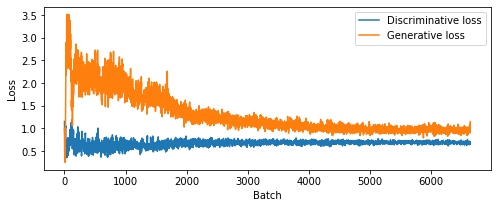

---------------Epoch 18---------------


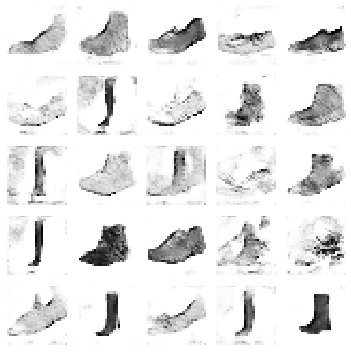

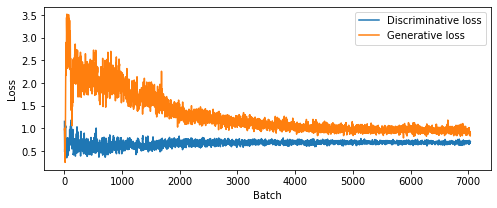

---------------Epoch 19---------------


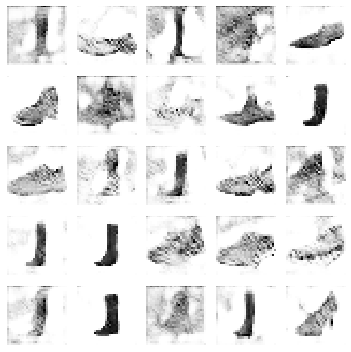

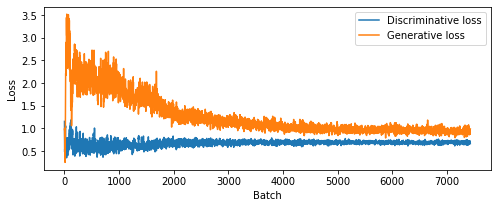

---------------Epoch 20---------------


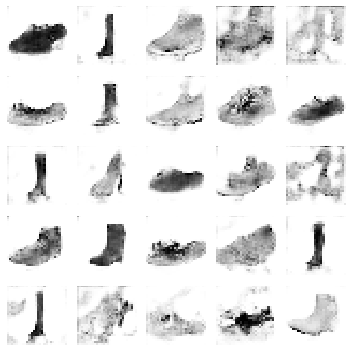

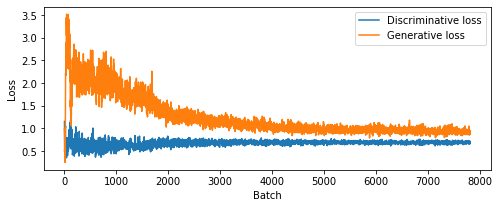

In [18]:
g, d, gan = create_gan_model()

# train_gan(200, 128)   ## practical is 200 epochs
train_gan(20, 128)      ## change to 20 epochs to reduce run time

# Change from load Fashion MNIST dataset to load Zappos grayscale dataset

### Go to 6.2.3 
### Revise Codes to change from load Fashion MNIST dataset to load Zappos grayscale dataset
### Re-run 6.2.3, 6.2.6 and 6.2.7
### Continue to run 6.2.8 and 6.2.9 (last cell)

## Section 6.2.8 - Generating Colours with our DCGANs

We've preprocessed our original Zappos data set with colours. 

To load up our RGB images stored in "x.npy" to pass it to our GAN for training.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 6272)              68992     
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 28, 128)      

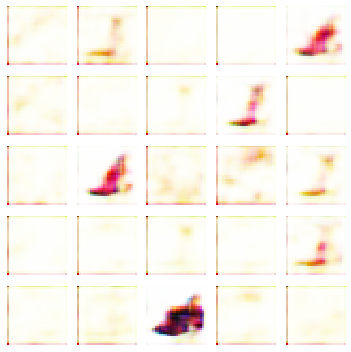

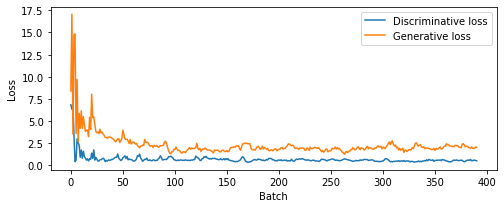

---------------Epoch 2---------------


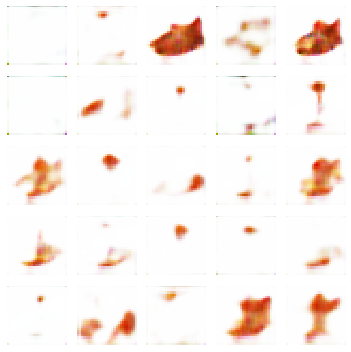

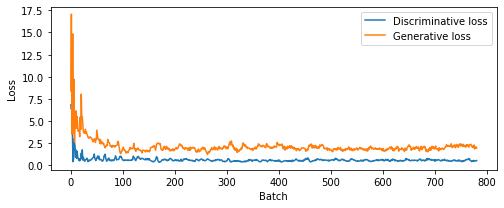

---------------Epoch 3---------------


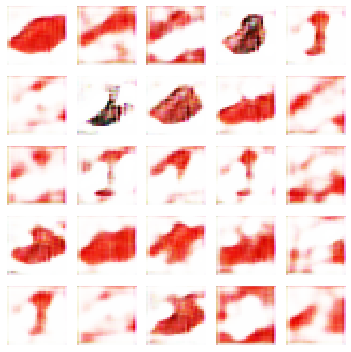

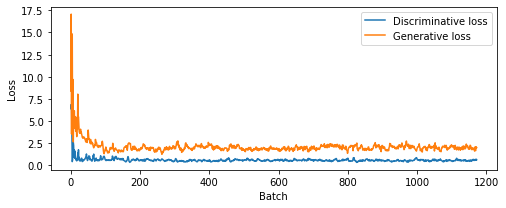

---------------Epoch 4---------------


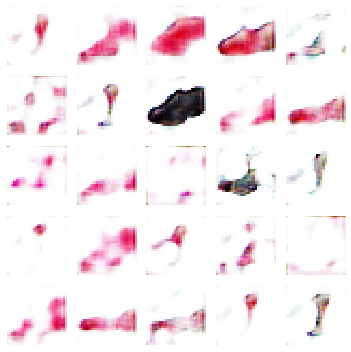

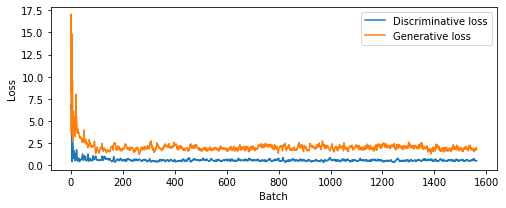

---------------Epoch 5---------------


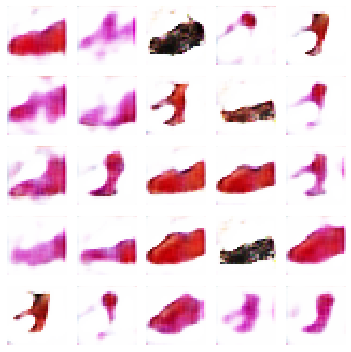

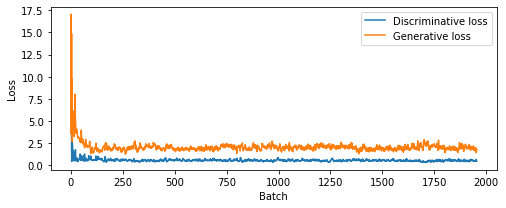

---------------Epoch 6---------------


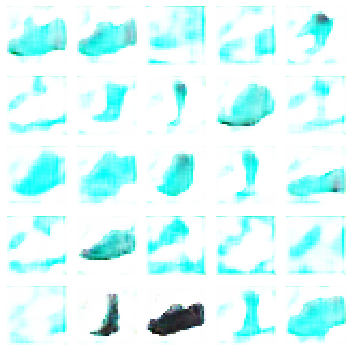

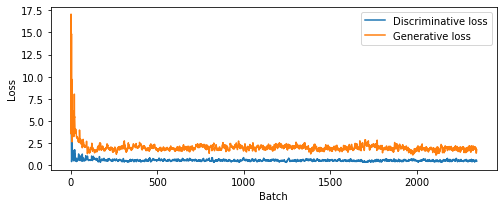

---------------Epoch 7---------------


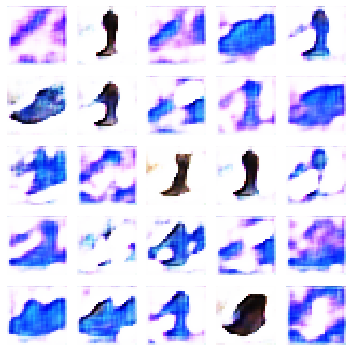

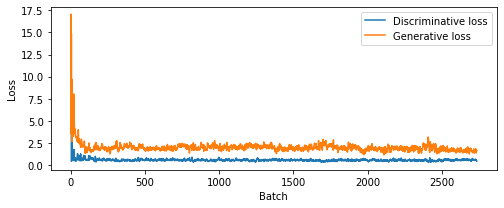

---------------Epoch 8---------------


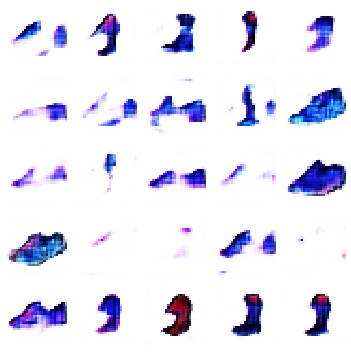

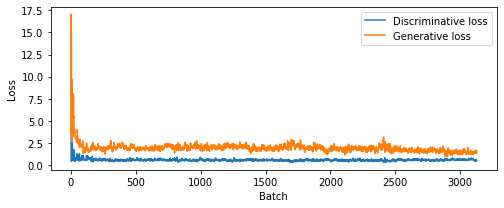

---------------Epoch 9---------------


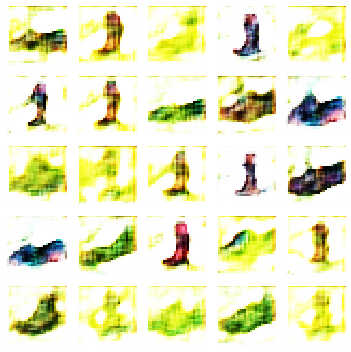

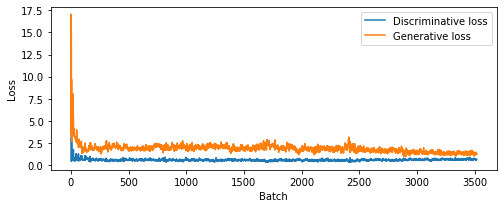

---------------Epoch 10---------------


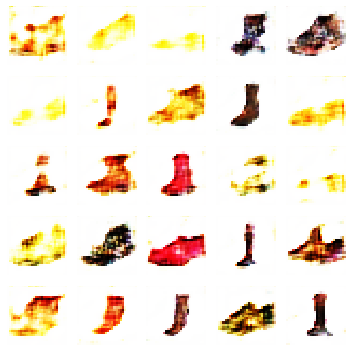

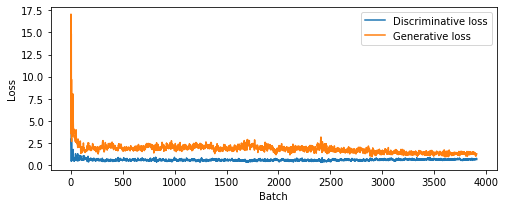

---------------Epoch 11---------------


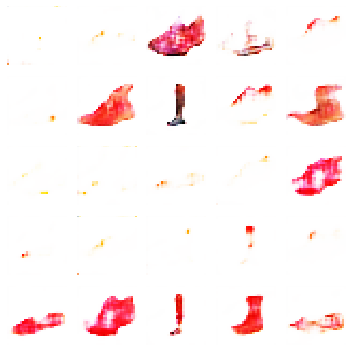

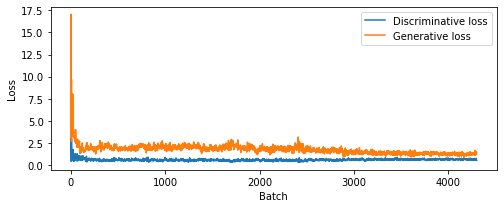

---------------Epoch 12---------------


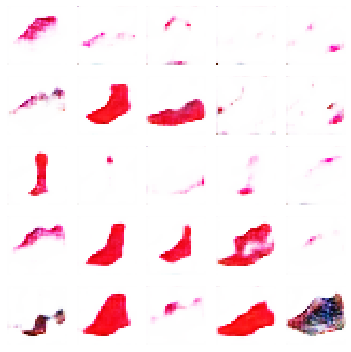

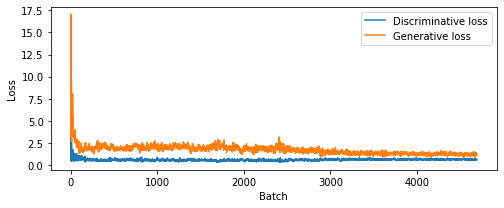

---------------Epoch 13---------------


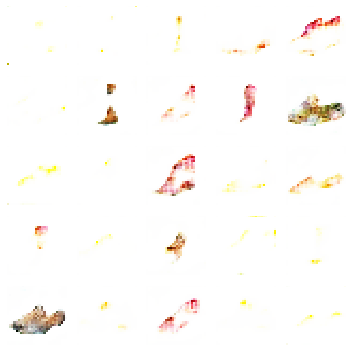

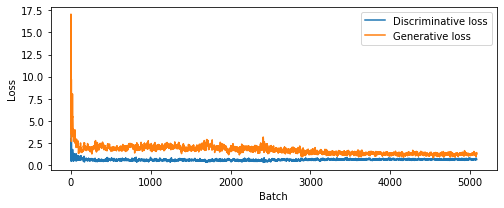

---------------Epoch 14---------------


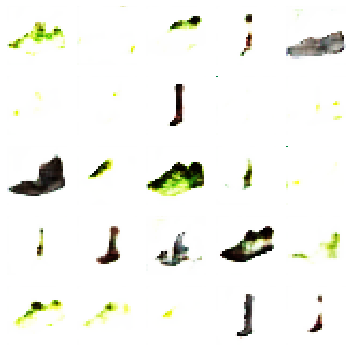

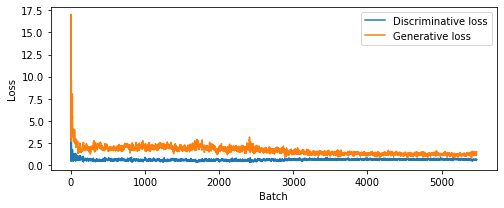

---------------Epoch 15---------------


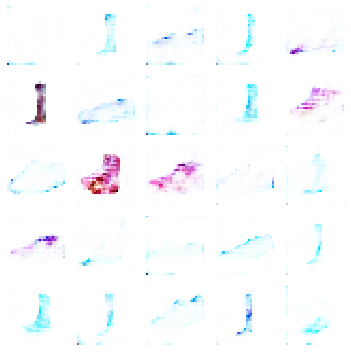

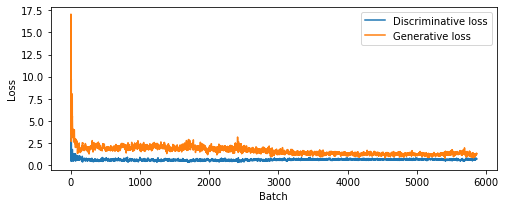

---------------Epoch 16---------------


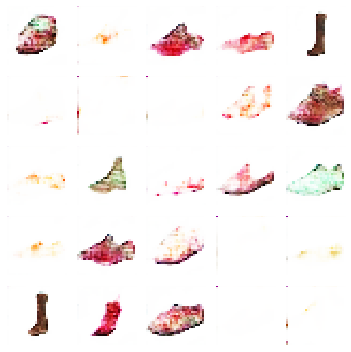

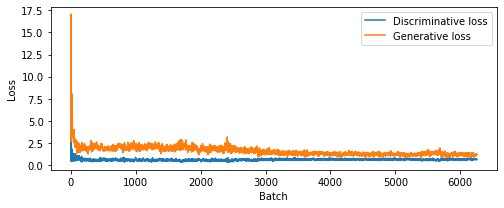

---------------Epoch 17---------------


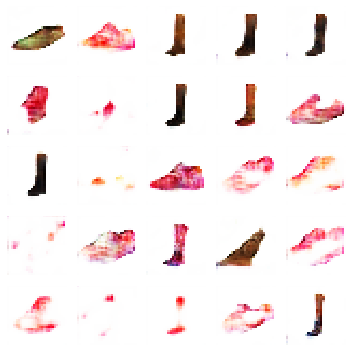

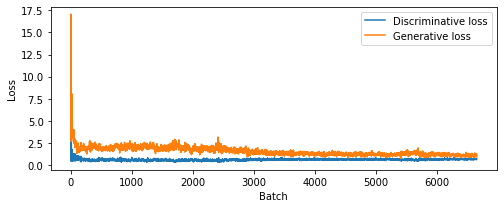

---------------Epoch 18---------------


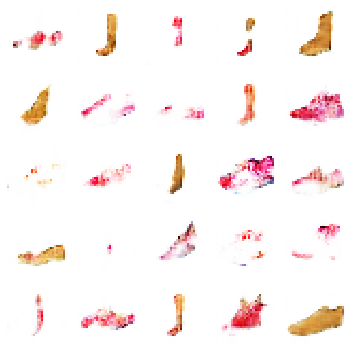

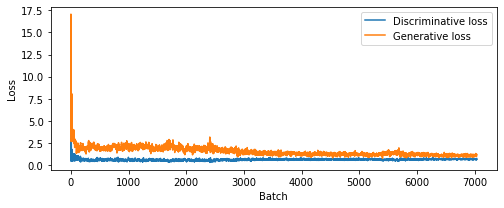

---------------Epoch 19---------------


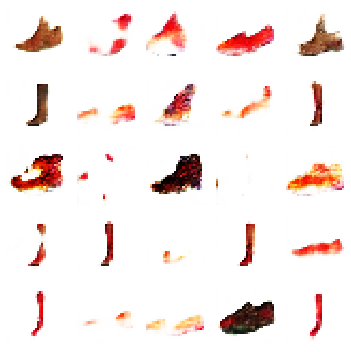

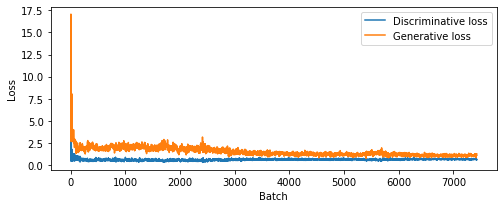

---------------Epoch 20---------------


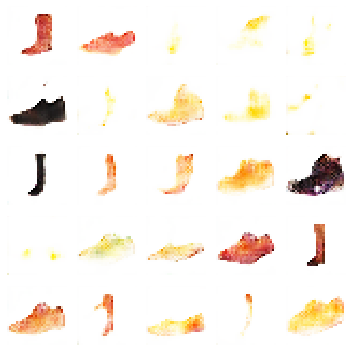

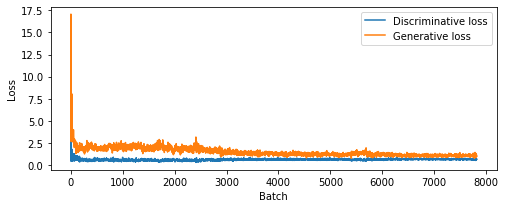

In [19]:

# TODO:
# Load up our coloured shoe images, and perform training.
# Make any changes necessary to the create_generator_model,
# create_discriminator_model 
#
channels = 3
x_train = np.load(folder + "x.npy")
x_train = x_train.reshape((x_train.shape[0], height, width, channels))
x_train = x_train / 127.5 - 1.   # rescales the image's RGB components from -1 to 1

g, d, gan = create_gan_model()

# train_gan(200, 128)   ## practical is 200 epochs
train_gan(20, 128)      ## change to 20 epochs to reduce run time

## Section 6.2.9 - Let's Use Our Generator Network!

Let's see how we can use our generator network to generate new images! 

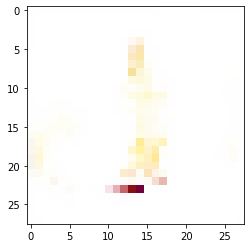

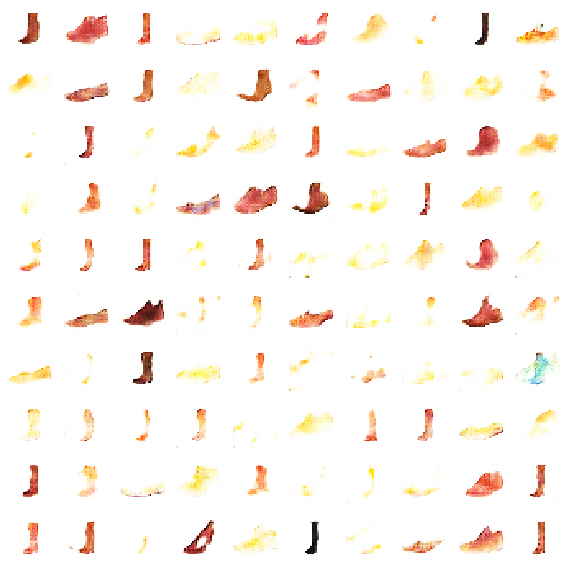

In [20]:
# First we generate the input to our generator.
# Remember the 'noise' is really 'features' that our
# generator has learnt to assign its own meaning to each
# element in the noise array (even though that meaning
# may not be apparent to us)
#
# You can try to assign values into the nosie array yourself
# to see what happens to the output!
#
# TODO:
noise = np.random.normal(0, 1, size=[1, randomDim])

# TODO:
# generate the output image
#
output = g.predict(noise)

# Plot the image
#
output = output.reshape(output.shape[1], output.shape[2], channels)
output = normalize(output)
plt.imshow(output)

plotGeneratedImages(0, g, examples=100, dim=(10, 10))

